# Preparation


In [13]:
# Install pupil_apriltags package. This a wrapper for the Apriltags3 library
#   developed by AprilRobotics.
# Documentation at https://github.com/pupil-labs/apriltags

%pip install pupil-apriltags

In [14]:
# Install gdown for downloading from Google Drive
%pip install gdown

In [15]:
# Import any required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O

# Use this line to make matplotlib plot non-interactive
# Notes:
#   - only need to call this once when importing matplotlib
#   - if switching to interactive mode (%matplotlib notebook) then re-import matplotlib.pyplot
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 7]

In [16]:
# Fetch and import ES143 helper functions
!wget -q https://raw.githubusercontent.com/Harvard-CS283/pset-data/refs/heads/main/misc/es143_utils.py -O es143_utils.py

from es143_utils import viz_board_calibration, detect_aprilboard, add_plotly_camera

In [17]:
# Fetch and import 3D-coordinates for the four AprilBoards, as well as images of the boards!wget -q https://raw.githubusercontent.com/Harvard-CS283/pset-data/main/april/AprilBoardA.png -O AprilBoardA.png
!wget -q https://raw.githubusercontent.com/Harvard-CS283/pset-data/main/april/AprilBoards2.pickle -O AprilBoards2.pickle

with open("AprilBoards2.pickle", "rb") as f:
    data = pickle.load(f)

at_board_a = data['at_board_a']
at_board_b = data['at_board_b']
at_board_c = data['at_board_c']
at_board_d = data['at_board_d']

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%cd "/content/drive/My Drive/es-143-assignments-group/Final/"

/content/drive/.shortcut-targets-by-id/19Pdu7se_x-HNkgpKZY4Uh-6wL6sCKqwX/es-143-assignments-group/Final


# Mirror

In [20]:
TARGET_WIDTH = 4032
TARGET_HEIGHT = 3024

def pad_image(image, target_width, target_height):
    h, w = image.shape[:2]
    pad_h = target_height - h
    pad_w = target_width - w

    if pad_h < 0 or pad_w < 0:
        print(f"Warning: Image ({w}x{h}) is larger than target ({target_width}x{target_height}). Cropping may occur.")
        start_h = max(0, (h - target_height) // 2)
        start_w = max(0, (w - target_width) // 2)
        cropped_image = image[start_h:start_h+target_height, start_w:start_w+target_width]
        return cropped_image

    top = pad_h // 2
    bottom = pad_h - top
    left = 0
    right = pad_w

    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded_image


In [21]:
def CalibrateCamera(filename, at_board_c):
    # Edit this line to point to the collection of input calibration image
    CALIBFILES = filename+'_0*.png'

    # The calibrations images use Board C
    BOARD = at_board_c

    ###### BEGIN CALIBRATION SCRIPT

    # exit if no images are found or if BOARD is unrecognized
    images = sorted(glob.glob(CALIBFILES))
    assert images, "no calibration images matching: " + CALIBFILES

    # else continue
    print("{} images:".format(len(images)))

    # initialize 3D object points and 2D image points
    calObjPoints = []
    calImgPoints = []
    caltagIDs = []
    imgs = []

    # define the number of columns for the plot, then calculate number of rows
    num_plot_cols = 5
    num_plot_rows = (len(images) + num_plot_cols - 1) // num_plot_cols

    # create the figure and axes; flatten the axes array for convenvience
    fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize=(12, 4*num_plot_rows))
    axs = axs.flatten()

    # loop through the images
    for count,fname in enumerate(images):

        # read image and convert to grayscale if necessary
        orig = cv2.imread(fname)
        if len(orig.shape) == 3:
            img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
        else:
            img = orig

        # Pad the image to the target size
        padded_img = pad_image(img, TARGET_WIDTH, TARGET_HEIGHT)

        # detect apriltags and report number of detections
        imgpoints, objpoints, tagIDs = detect_aprilboard(padded_img, BOARD)

        print(f"{count} {fname}: {len(imgpoints)} imgpts, {len(objpoints)} objpts")

        # append detections if some are found
        if len(imgpoints) and len(objpoints):
            imgs.append(img)

            # show image
            axs[count].imshow(padded_img / 255.0, cmap="gray")
            axs[count].set_axis_off()
            axs[count].set_title("Image {}".format(count))

            # display detected tag centers
            axs[count].scatter(imgpoints[:,0], imgpoints[:,1], marker='o', color='#ff7f0e')

            # append points detected in all images, (there is only one image now)
            calObjPoints.append(objpoints.astype('float32'))
            calImgPoints.append(imgpoints.astype('float32'))
            caltagIDs.append(tagIDs)

    # show the plot
    plt.tight_layout()

    plt.show()

    # Use the predefined target image size for calibration
    calibration_image_size = (TARGET_WIDTH, TARGET_HEIGHT) # (width, height)

    # calibrate the camera
    reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
        calObjPoints,
        calImgPoints,
        calibration_image_size,
        None,
        None,
        flags = (
    cv2.CALIB_FIX_PRINCIPAL_POINT |
    cv2.CALIB_ZERO_TANGENT_DIST |
    cv2.CALIB_FIX_K3 |
    cv2.CALIB_FIX_K4 |
    cv2.CALIB_FIX_K5
))


    fig2, axs2 = plt.subplots(num_plot_rows, num_plot_cols, figsize=(12, 4*num_plot_rows))
    axs2 = axs2.flatten()

    total_error = 0
    total_points = 0

    for i in range(len(imgs)):
        img = imgs[i]
        objp = calObjPoints[i]
        imgp_detected = calImgPoints[i]

        # Project object points back using calibration results
        imgp_projected, _ = cv2.projectPoints(objp, calRotations[i], calTranslations[i], calMatrix, distCoeffs)
        imgp_projected = imgp_projected.reshape(-1, 2)

        # Compute per-image reprojection RMSE
        error = np.sqrt(np.mean(np.sum((imgp_detected - imgp_projected)**2, axis=1)))
        total_error += error * len(objp)
        total_points += len(objp)

        axs2[i].imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
        axs2[i].scatter(imgp_detected[:,0], imgp_detected[:,1], c='blue', s=10, label='Detected')
        axs2[i].scatter(imgp_projected[:,0], imgp_projected[:,1], c='red', s=10, label='Projected')
        axs2[i].set_title(f"Image {i} - err={error:.2f}px")
        axs2[i].axis('off')

    plt.legend()
    plt.suptitle("Detected (blue) vs Projected (red) points")
    plt.tight_layout()
    plt.show()

    mean_err = total_error / total_points
    print(f"\nMean per-point reprojection RMSE: {mean_err:.3f} pixels")


    return reprojerr, calMatrix, distCoeffs, calRotations, calTranslations, calObjPoints, calImgPoints, imgs, caltagIDs

In [12]:
ret_l, calMatrix_left, distCoeffs_left, calRotations_left, calTranslations_left, calObjPoints_left, calImgPoints_left, imgs_left, caltagIDs_left = CalibrateCamera('./data_mirror/left_half', at_board_c)
ret_r, calMatrix_right, distCoeffs_right, calRotations_right, calTranslations_right, calObjPoints_right, calImgPoints_right, imgs_right, caltagIDs_right = CalibrateCamera('./data_mirror/right_half', at_board_c)

print(f"ret_l: {ret_l}")
print(f"ret_r: {ret_r}")


Output hidden; open in https://colab.research.google.com to view.

In [22]:
objpoints_stereo = []
imgpoints_left_stereo = []
imgpoints_right_stereo = []

for i in range(len(caltagIDs_left)):
    if i >= len(caltagIDs_right):
        break

    idsL = caltagIDs_left[i]
    idsR = caltagIDs_right[i]
    common = np.intersect1d(idsL, idsR)

    print(f"{i} {len(idsL)} {len(idsR)} {len(common)}")

    if len(common) < 5:
        continue

    idxL = np.nonzero(np.isin(idsL, common))[0]
    idxR = np.nonzero(np.isin(idsR, common))[0]

    order = np.argsort(common)
    idxL = idxL[order]
    idxR = idxR[order]

    objpoints_stereo.append(calObjPoints_left[i][idxL])
    imgpoints_left_stereo.append(calImgPoints_left[i][idxL])
    imgpoints_right_stereo.append(calImgPoints_right[i][idxR])

stereo_image_size = (TARGET_WIDTH, TARGET_HEIGHT) # (width, height)

retval, calMatrix_left, distCoeffs_left, calMatrix_right, distCoeffs_right, R, T, E, F = cv2.stereoCalibrate(
    objpoints_stereo,
    imgpoints_left_stereo,
    imgpoints_right_stereo,
    calMatrix_left, distCoeffs_left,
    calMatrix_right, distCoeffs_right,
    stereo_image_size,
    flags=cv2.CALIB_FIX_INTRINSIC
)

print(f"R: {R}")
print(f"T: {T}")
print(f"E: {E}")
print(f"F: {F}")
print(f"retval: {retval}")

0 80 80 80
1 80 80 80
2 80 77 77
3 80 77 77
4 80 72 72
5 80 72 72
6 80 78 78
7 80 79 79
8 80 80 80
9 79 80 79
10 79 78 77
11 78 78 77
12 80 80 80
13 80 78 78
14 80 77 77
R: [[ 9.96048024e-01  2.54431178e-02  8.50939592e-02]
 [-2.52667117e-02  9.99675784e-01 -3.14958374e-03]
 [-8.51465056e-02  9.87092124e-04  9.96367953e-01]]
T: [[-0.32958993]
 [ 0.00950241]
 [-0.02909438]]
E: [[-1.54421605e-03  2.90943268e-02  9.37625850e-03]
 [-5.70428303e-02 -4.14916115e-04  3.25917086e-01]
 [-1.13719991e-03 -3.29724840e-01  2.29473653e-04]]
F: [[ 1.21673575e-08 -2.29435488e-07  1.62527435e-04]
 [ 4.47815302e-07  3.26003484e-09 -6.43977230e-03]
 [-6.82337637e-04  5.98804151e-03  1.00000000e+00]]
retval: 6.584760591348917


In [23]:
fig = viz_board_calibration(
    calMatrix_left,
    calObjPoints_left,
    calRotations_left,
    calTranslations_left,
    imgs_left[-1])
h, w = (TARGET_HEIGHT, TARGET_WIDTH)
camera_right = calMatrix_right @ np.hstack((R, T))
add_plotly_camera(h, w, camera_right, 2.0, fig)
fig.show()

In [24]:
print(calMatrix_left)
print(distCoeffs_left)
print(calMatrix_right)
print(distCoeffs_right)

[[2.16221368e+03 0.00000000e+00 2.01550000e+03]
 [0.00000000e+00 2.16040183e+03 1.51150000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.03934918  0.01902935  0.          0.          0.        ]]
[[2.12698161e+03 0.00000000e+00 2.01550000e+03]
 [0.00000000e+00 2.13478467e+03 1.51150000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[0.00882716 0.00020336 0.         0.         0.        ]]


In [25]:
image_size = (int(TARGET_WIDTH), int(TARGET_HEIGHT))
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    calMatrix_left,
    distCoeffs_left,
    calMatrix_right,
    distCoeffs_right,
    image_size,
    R,
    T)

map1x, map1y = cv2.initUndistortRectifyMap(
    calMatrix_left, distCoeffs_left, R1, P1, image_size, cv2.CV_32FC1
)
map2x, map2y = cv2.initUndistortRectifyMap(
    calMatrix_right, distCoeffs_right, R2, P2, image_size, cv2.CV_32FC1
)

In [26]:
left_file = './data_mirror/scene_left_half_0*.png'
right_file = './data_mirror/scene_right_half_0*.png'

scenes_left = []
scenes_right = []

scene_left = glob.glob(left_file)
assert scene_left, "no calibration images matching: " + left_file
for file in scene_left:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = pad_image(img, TARGET_WIDTH, TARGET_HEIGHT)
    scenes_left.append(img)

scene_right = glob.glob(right_file)
assert scene_right, "no calibration images matching: " + right_file
for file in scene_right:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = pad_image(img, TARGET_WIDTH, TARGET_HEIGHT)
    scenes_right.append(img)

In [27]:
scenes_left_rectified = []
scenes_right_rectified = []

for scene_left, scene_right in zip(scenes_left, scenes_right):
  scene_left_rectified = cv2.remap(scene_left, map1x, map1y, cv2.INTER_LINEAR)
  scene_right_rectified = cv2.remap(scene_right, map2x, map2y, cv2.INTER_LINEAR)
  scenes_left_rectified.append(scene_left_rectified[200:2500,200:1300])
  scenes_right_rectified.append(scene_right_rectified[200:2500,200:1300])

In [28]:
combined = np.hstack((scenes_left_rectified[1], scenes_right_rectified[1]))

step = 50
for y in range(0, combined.shape[0], step):
    cv2.line(combined, (0, y), (combined.shape[1], y), (0, 255, 0), 1)

plt.figure(figsize=(20,20))
plt.imshow(combined, cmap='gray')
plt.title(f"Rectified Pair: Left  | Right")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [29]:
# @title
import os

output_dir = 'rectified_images_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(len(scenes_left_rectified)):
  output_path_left = os.path.join(output_dir, f'mirror_scene_left_half_{i+1}.png')
  output_path_right = os.path.join(output_dir, f'mirror_scene_right_half_{i+1}.png')
  cv2.imwrite(output_path_left, cv2.cvtColor(scenes_left_rectified[i], cv2.COLOR_RGB2BGR))
  cv2.imwrite(output_path_right, cv2.cvtColor(scenes_right_rectified[i], cv2.COLOR_RGB2BGR))



# Test

In [30]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple((int(pt1[0]), int(pt1[1]))),5,color,-1)
        img2 = cv2.circle(img2,tuple((int(pt2[0]), int(pt2[1]))),5,color,-1)
    return img1,img2

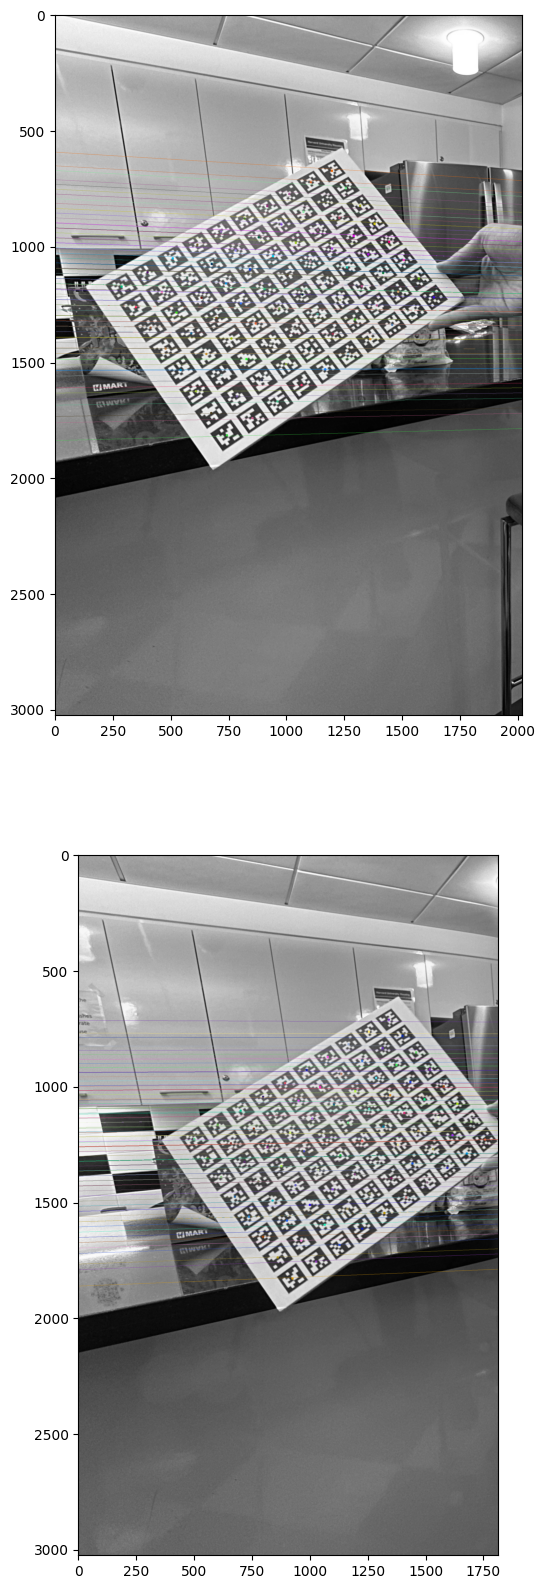

Mean epipolar error: 3.813 pixels


In [31]:
lines1 = cv2.computeCorrespondEpilines(calImgPoints_right[1].reshape(-1,1,2), 2, F)
lines2 = cv2.computeCorrespondEpilines(calImgPoints_left[1].reshape(-1,1,2), 1, F)

img5, img6 = drawlines(imgs_left[1], imgs_right[1], lines1.reshape(-1, 3), calImgPoints_left[1], calImgPoints_right[1])
img3, img4 = drawlines(imgs_right[1], imgs_left[1], lines2.reshape(-1, 3), calImgPoints_right[1], calImgPoints_left[1])
plt.figure(figsize=(20, 20))
plt.subplot(211),plt.imshow(img5)
plt.subplot(212),plt.imshow(img3)
plt.show()

def point_line_distance(pts, lines):
    lines = lines.reshape(-1, 3)
    a,b,c = lines[:,0], lines[:,1], lines[:,2]
    x,y = pts[:,0], pts[:,1]
    return np.abs(a*x + b*y + c) / np.sqrt(a**2 + b**2)

err_left  = point_line_distance(calImgPoints_left[1].reshape(-1,2), lines1)
err_right = point_line_distance(calImgPoints_right[1].reshape(-1,2), lines2)

mean_epipolar_err = 0.5*(np.mean(err_left) + np.mean(err_right))
print(f"Mean epipolar error: {mean_epipolar_err:.3f} pixels")

In [32]:
def disparity_range_from_geometry(P1, P2, Z_min, Z_max):
    f = P1[0,0]
    B = -P2[0,3] / P2[0,0]
    d_min = f * B / Z_max
    d_max = f * B / Z_min

    minDisp = int(np.floor(d_min))
    maxDisp = int(np.ceil(d_max))
    numDisp = int(np.ceil((maxDisp - minDisp)/16.0)*16)
    return minDisp, numDisp


minDisp, numDisp = disparity_range_from_geometry(P1, P2, Z_min=30, Z_max=150)
print(minDisp, numDisp)


4 32


# Two_camera

In [33]:
def CalibrateCamera(filename, at_board_c):
    # Edit this line to point to the collection of input calibration image
    CALIBFILES = filename+'_0*.png'

    # The calibrations images use Board C
    BOARD = at_board_c

    ###### BEGIN CALIBRATION SCRIPT

    # exit if no images are found or if BOARD is unrecognized
    images = sorted(glob.glob(CALIBFILES))
    assert images, "no calibration images matching: " + CALIBFILES

    # else continue
    print("{} images:".format(len(images)))

    # initialize 3D object points and 2D image points
    calObjPoints = []
    calImgPoints = []
    caltagIDs = []
    imgs = []

    # define the number of columns for the plot, then calculate number of rows
    num_plot_cols = 5
    num_plot_rows = (len(images) + num_plot_cols - 1) // num_plot_cols

    # create the figure and axes; flatten the axes array for convenvience
    fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize=(12, 4*num_plot_rows))
    axs = axs.flatten()

    # loop through the images
    for count,fname in enumerate(images):

        # read image and convert to grayscale if necessary
        orig = cv2.imread(fname)
        if len(orig.shape) == 3:
            img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
        else:
            img = orig

        # detect apriltags and report number of detections
        imgpoints, objpoints, tagIDs = detect_aprilboard(img, BOARD)

        print(f"{count} {fname}: {len(imgpoints)} imgpts, {len(objpoints)} objpts")

        # append detections if some are found
        if len(imgpoints) and len(objpoints):
            imgs.append(img)

            # show image
            axs[count].imshow(img / 255.0, cmap="gray")
            axs[count].set_axis_off()
            axs[count].set_title("Image {}".format(count))

            # display detected tag centers
            axs[count].scatter(imgpoints[:,0], imgpoints[:,1], marker='o', color='#ff7f0e')

            # append points detected in all images, (there is only one image now)
            calObjPoints.append(objpoints.astype('float32'))
            calImgPoints.append(imgpoints.astype('float32'))
            caltagIDs.append(tagIDs)

    # show the plot
    plt.tight_layout()

    plt.show()

    # Use the predefined target image size for calibration
    calibration_image_size = (3024, 4032) # (width, height)

    # calibrate the camera
    reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
        calObjPoints,
        calImgPoints,
        calibration_image_size,
        None,
        None,
        flags = None)


    fig2, axs2 = plt.subplots(num_plot_rows, num_plot_cols, figsize=(12, 4*num_plot_rows))
    axs2 = axs2.flatten()

    total_error = 0
    total_points = 0

    for i in range(len(imgs)):
        img = imgs[i]
        objp = calObjPoints[i]
        imgp_detected = calImgPoints[i]

        # Project object points back using calibration results
        imgp_projected, _ = cv2.projectPoints(objp, calRotations[i], calTranslations[i], calMatrix, distCoeffs)
        imgp_projected = imgp_projected.reshape(-1, 2)

        # Compute per-image reprojection RMSE
        error = np.sqrt(np.mean(np.sum((imgp_detected - imgp_projected)**2, axis=1)))
        total_error += error * len(objp)
        total_points += len(objp)

        axs2[i].imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
        axs2[i].scatter(imgp_detected[:,0], imgp_detected[:,1], c='blue', s=10, label='Detected')
        axs2[i].scatter(imgp_projected[:,0], imgp_projected[:,1], c='red', s=10, label='Projected')
        axs2[i].set_title(f"Image {i} - err={error:.2f}px")
        axs2[i].axis('off')

    plt.legend()
    plt.suptitle("Detected (blue) vs Projected (red) points")
    plt.tight_layout()
    plt.show()

    mean_err = total_error / total_points
    print(f"\nMean per-point reprojection RMSE: {mean_err:.3f} pixels")


    return reprojerr, calMatrix, distCoeffs, calRotations, calTranslations, calObjPoints, calImgPoints, imgs, caltagIDs

In [34]:
ret_l, calMatrix_left, distCoeffs_left, calRotations_left, calTranslations_left, calObjPoints_left, calImgPoints_left, imgs_left, caltagIDs_left = CalibrateCamera('./data_two/left', at_board_c)
ret_r, calMatrix_right, distCoeffs_right, calRotations_right, calTranslations_right, calObjPoints_right, calImgPoints_right, imgs_right, caltagIDs_right = CalibrateCamera('./data_two/right', at_board_c)

print(f"ret_l: {ret_l}")
print(f"ret_r: {ret_r}")


Output hidden; open in https://colab.research.google.com to view.

In [35]:
objpoints_stereo = []
imgpoints_left_stereo = []
imgpoints_right_stereo = []

for i in range(len(caltagIDs_left)):
    if i >= len(caltagIDs_right):
        break

    idsL = caltagIDs_left[i]
    idsR = caltagIDs_right[i]
    common = np.intersect1d(idsL, idsR)

    print(f"{i} {len(idsL)} {len(idsR)} {len(common)}")

    if len(common) < 5:
        continue

    idxL = np.nonzero(np.isin(idsL, common))[0]
    idxR = np.nonzero(np.isin(idsR, common))[0]

    order = np.argsort(common)
    idxL = idxL[order]
    idxR = idxR[order]

    objpoints_stereo.append(calObjPoints_left[i][idxL])
    imgpoints_left_stereo.append(calImgPoints_left[i][idxL])
    imgpoints_right_stereo.append(calImgPoints_right[i][idxR])

# Get the image size from one of the captured images (assuming they are all the same size after individual calibration)
stereo_image_size = (3024, 4032) # (width, height)

retval, calMatrix_left, distCoeffs_left, calMatrix_right, distCoeffs_right, R, T, E, F = cv2.stereoCalibrate(
    objpoints_stereo,
    imgpoints_left_stereo,
    imgpoints_right_stereo,
    calMatrix_left, distCoeffs_left,
    calMatrix_right, distCoeffs_right,
    stereo_image_size,
    flags=cv2.CALIB_FIX_INTRINSIC
)

print(f"R: {R}")
print(f"T: {T}")
print(f"E: {E}")
print(f"F: {F}")
print(f"retval: {retval}")

0 80 80 80
1 80 80 80
2 80 80 80
3 80 80 80
4 80 80 80
5 80 80 80
6 80 80 80
7 80 80 80
8 80 80 80
9 80 80 80
R: [[ 0.88892469 -0.11905118  0.44231178]
 [ 0.17867737  0.97926031 -0.09551776]
 [-0.42176687  0.1639392   0.89176042]]
T: [[-14.0940007 ]
 [ -0.24025896]
 [  3.16394321]]
E: [[ -0.46399177  -3.13771187   0.08795933]
 [ -3.13187535   1.93388801  13.96792133]
 [ -2.30470682 -13.83029862   1.45249672]]
F: [[-9.40711294e-08 -6.36264208e-07  1.44995845e-03]
 [-6.36567584e-07  3.93142258e-07  8.18948974e-03]
 [ 1.26114181e-04 -7.67381268e-03  1.00000000e+00]]
retval: 1.4755137959319435


In [36]:
fig = viz_board_calibration(
    calMatrix_left,
    calObjPoints_left,
    calRotations_left,
    calTranslations_left,
    imgs_left[-1])
h, w = (4032, 3024)
camera_right = calMatrix_right @ np.hstack((R, T))
add_plotly_camera(h, w, camera_right, 2.0, fig)
fig.show()

In [37]:
image_size = imgs_left[0].shape[::-1]
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    calMatrix_left,
    distCoeffs_left,
    calMatrix_right,
    distCoeffs_right,
    image_size,
    R,
    T, alpha=1)

map1x, map1y = cv2.initUndistortRectifyMap(
    calMatrix_left, distCoeffs_left, R1, P1, image_size, cv2.CV_32FC1
)
map2x, map2y = cv2.initUndistortRectifyMap(
    calMatrix_right, distCoeffs_right, R2, P2, image_size, cv2.CV_32FC1
)

In [38]:
left_file = './data_two/scene_left_0*.png'
right_file = './data_two/scene_right_0*.png'

scenes_left = []
scenes_right = []

scene_left = glob.glob(left_file)
assert scene_left, "no calibration images matching: " + left_file
for file in scene_left:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    scenes_left.append(img)

scene_right = glob.glob(right_file)
assert scene_right, "no calibration images matching: " + right_file
for file in scene_right:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    scenes_right.append(img)

In [39]:
scenes_left_rectified = []
scenes_right_rectified = []

for scene_left, scene_right in zip(scenes_left, scenes_right):
  scene_left_rectified = cv2.remap(scene_left, map1x, map1y, cv2.INTER_LINEAR)
  scene_right_rectified = cv2.remap(scene_right, map2x, map2y, cv2.INTER_LINEAR)
  y0 = max(roi1[1], roi2[1])
  y1 = min(roi1[1] + roi1[3], roi2[1] + roi2[3])
  x, y, w, h = roi1
  scenes_left_rectified.append(scene_left_rectified[y0:y1, x:x+w])
  x, y, w, h = roi2
  scenes_right_rectified.append(scene_right_rectified[y0:y1, x:x+w])

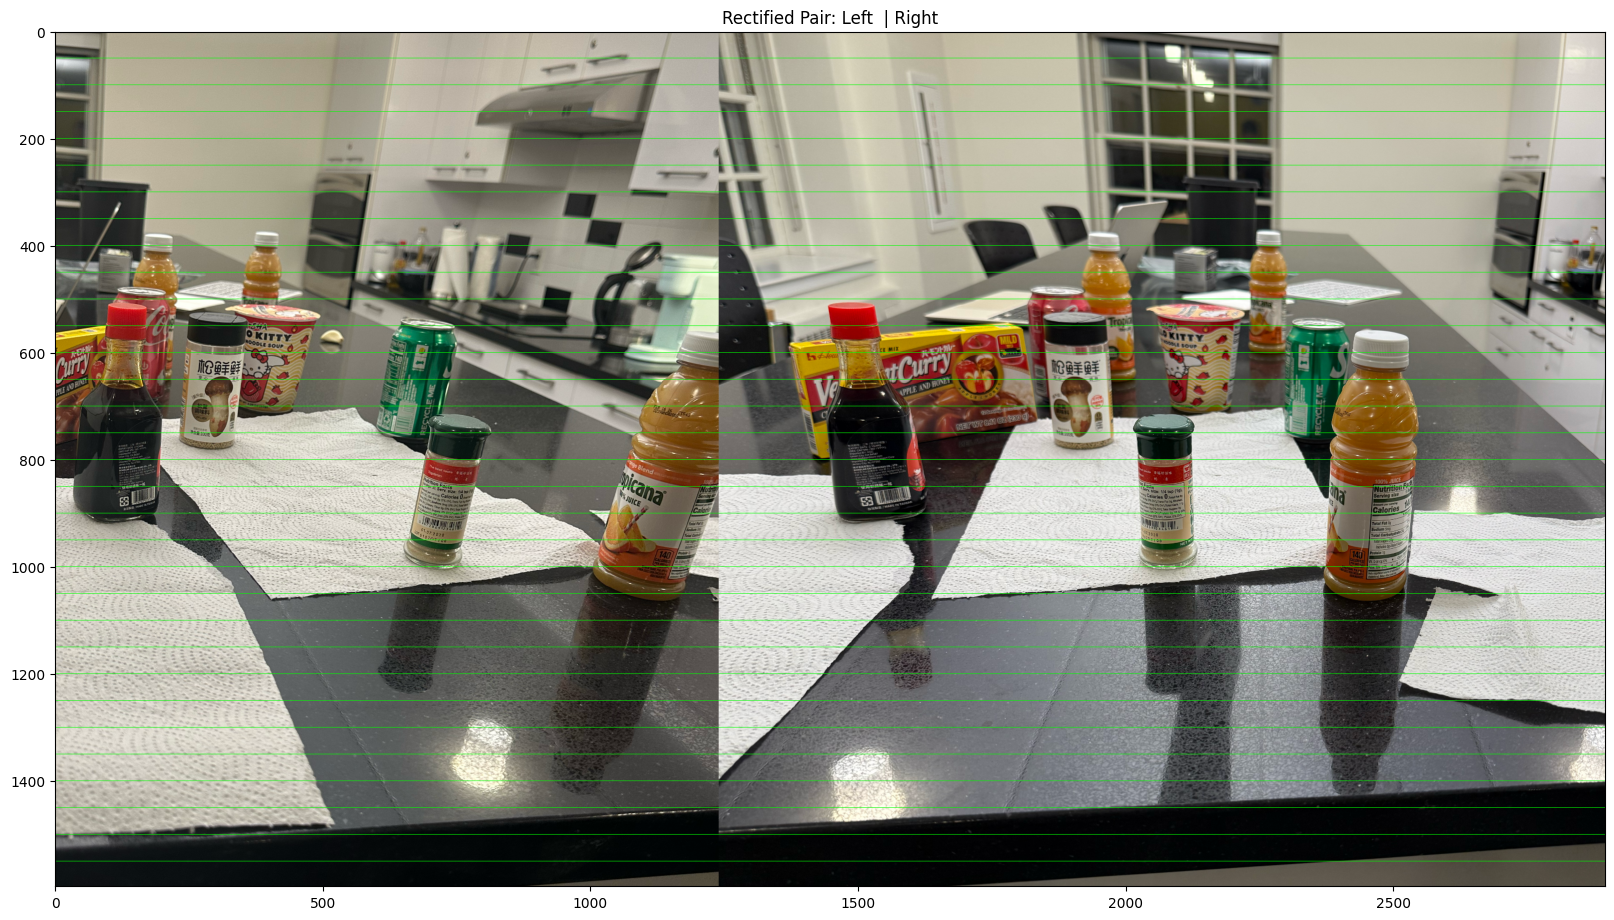

In [40]:
combined = np.hstack((scenes_left_rectified[0], scenes_right_rectified[0]))

step = 50
for y in range(0, combined.shape[0], step):
    cv2.line(combined, (0, y), (combined.shape[1], y), (0, 255, 0), 1)

plt.figure(figsize=(20,20))
plt.imshow(combined, cmap='gray')
plt.title(f"Rectified Pair: Left  | Right")
plt.show()

In [41]:
import os

output_dir = 'rectified_images_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(len(scenes_left_rectified)):
  output_path_left = os.path.join(output_dir, f'two_scene_left_{i+1}.png')
  output_path_right = os.path.join(output_dir, f'two_scene_right_{i+1}.png')
  cv2.imwrite(output_path_left, cv2.cvtColor(scenes_left_rectified[i], cv2.COLOR_RGB2BGR))
  cv2.imwrite(output_path_right, cv2.cvtColor(scenes_right_rectified[i], cv2.COLOR_RGB2BGR))

In [42]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple((int(pt1[0]), int(pt1[1]))),5,color,-1)
        img2 = cv2.circle(img2,tuple((int(pt2[0]), int(pt2[1]))),5,color,-1)
    return img1,img2

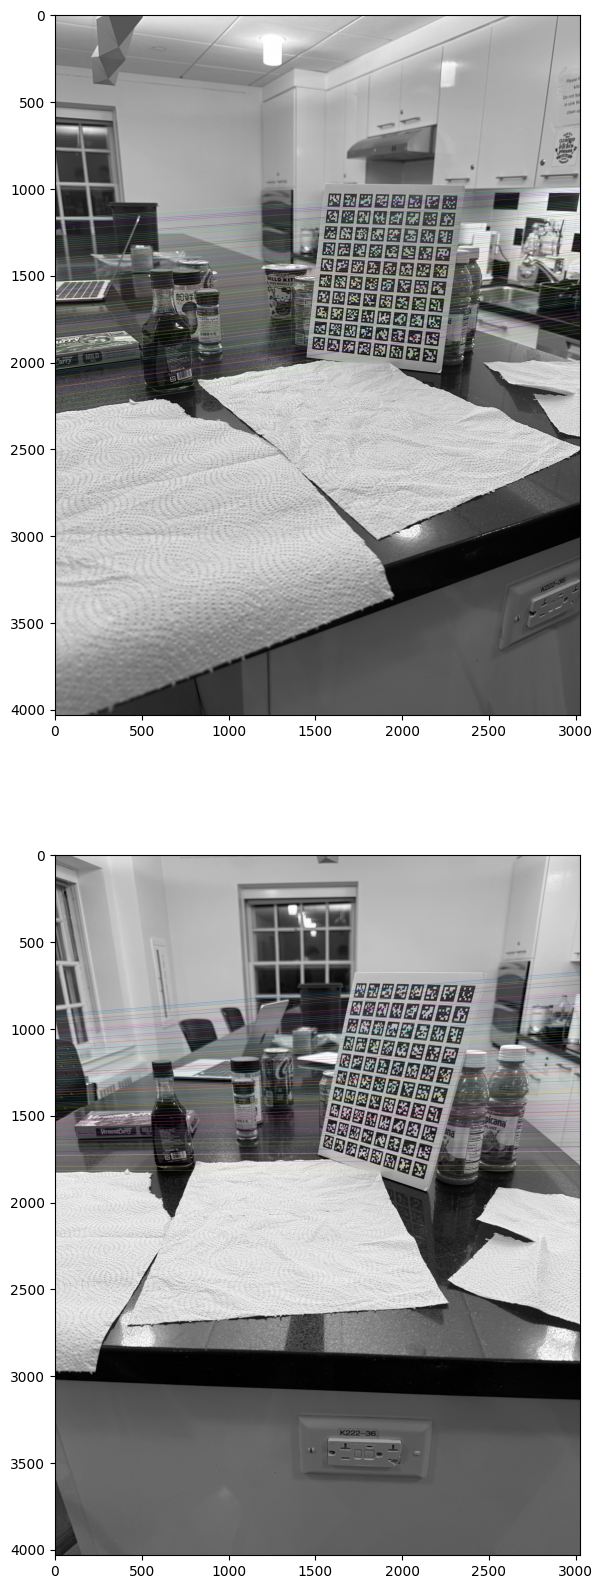

Mean epipolar error: 1.606 pixels


In [43]:
lines1 = cv2.computeCorrespondEpilines(calImgPoints_right[1].reshape(-1,1,2), 2, F)
lines2 = cv2.computeCorrespondEpilines(calImgPoints_left[1].reshape(-1,1,2), 1, F)

img5, img6 = drawlines(imgs_left[1], imgs_right[1], lines1.reshape(-1, 3), calImgPoints_left[1], calImgPoints_right[1])
img3, img4 = drawlines(imgs_right[1], imgs_left[1], lines2.reshape(-1, 3), calImgPoints_right[1], calImgPoints_left[1])
plt.figure(figsize=(20, 20))
plt.subplot(211),plt.imshow(img5)
plt.subplot(212),plt.imshow(img3)
plt.show()

def point_line_distance(pts, lines):
    lines = lines.reshape(-1, 3)
    a,b,c = lines[:,0], lines[:,1], lines[:,2]
    x,y = pts[:,0], pts[:,1]
    return np.abs(a*x + b*y + c) / np.sqrt(a**2 + b**2)

err_left  = point_line_distance(calImgPoints_left[1].reshape(-1,2), lines1)
err_right = point_line_distance(calImgPoints_right[1].reshape(-1,2), lines2)

mean_epipolar_err = 0.5*(np.mean(err_left) + np.mean(err_right))
print(f"Mean epipolar error: {mean_epipolar_err:.3f} pixels")

In [44]:
def disparity_range_from_geometry(P1, P2, Z_min, Z_max):
    f = P1[0,0]
    B = -P2[0,3] / P2[0,0]
    d_min = f * B / Z_max
    d_max = f * B / Z_min

    minDisp = int(np.floor(d_min))
    maxDisp = int(np.ceil(d_max))
    numDisp = int(np.ceil((maxDisp - minDisp)/16.0)*16)
    return minDisp, numDisp


minDisp, numDisp = disparity_range_from_geometry(P1, P2, Z_min=30, Z_max=150)
print(minDisp, numDisp)


146 592
